In [1]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from kymatio.torch import Scattering2D

print(torch.cuda.is_available())

ranges_dict = dict(
    params = {
        0: [4, 6], # ION_Tvir_MIN
        1: [10, 250], # HII_EFF_FACTOR
        },
    images = {
        0: [0, 80], # brightness_temp
        }
    )

True


In [2]:
def load_h5_as_tensor(dir_name='/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5'):
    dataset = Dataset4h5(dir_name, num_image=192, num_redshift=64, HII_DIM=64, rescale=False, dim=2)

    with h5py.File(dir_name) as f:
        print(f.keys())
        print(f['redshifts_distances'])
        los = f['redshifts_distances'][:,-dataset.num_redshift:]

    dataloader = DataLoader(dataset, batch_size=192)
    
    x, c = next(iter(dataloader))
    print("x.shape =", x.shape)
    print("c.shape =", c.shape)
    print("x.min() =", x.min())
    print("x.max() =", x.max())
    return x, c, los

In [3]:
x0, c0, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5')
x1, c1, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.6-19.037.h5')
x2, c2, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.699-30.h5')
x3, c3, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.477-200.h5')
x4, c4, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.8-131.341.h5')

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 192 images randomly
images loaded: (192, 1, 64, 64)
params loaded: (192, 2)
images rescaled to [0.0, 42.50267791748047]
params rescaled to [4.4, 131.341]
<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "redshifts_distances": shape (2, 514), type "<f8">
x.shape = torch.Size([192, 1, 64, 64])
c.shape = torch.Size([192, 2])
x.min() = tensor(0.)
x.max() = tensor(42.5027)
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 192 images randomly
images loaded: (192, 1, 64, 64)
params loaded: (192, 2)
imag

In [4]:
los.shape

(2, 64)

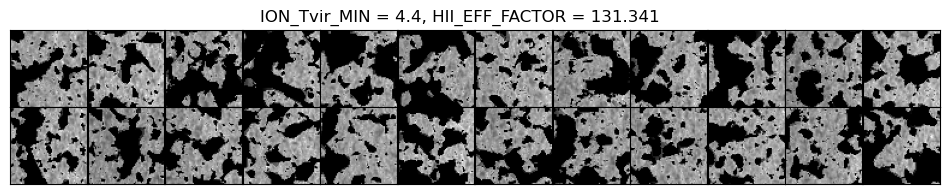

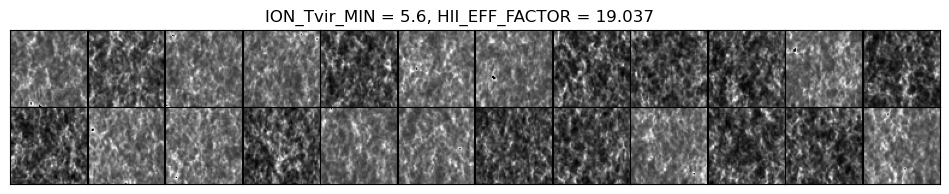

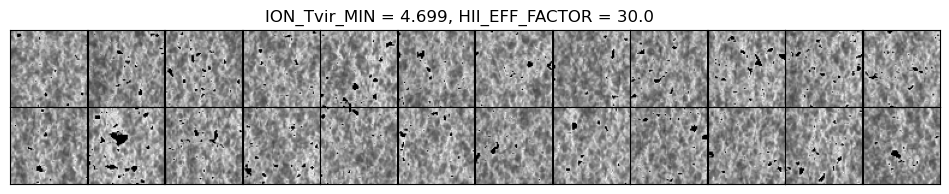

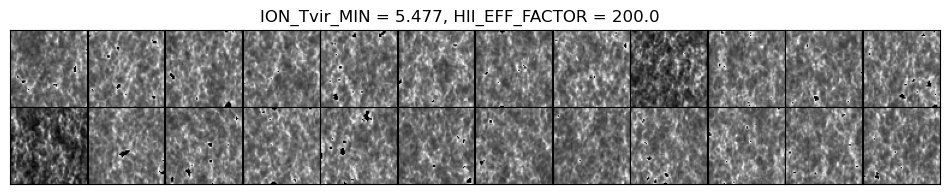

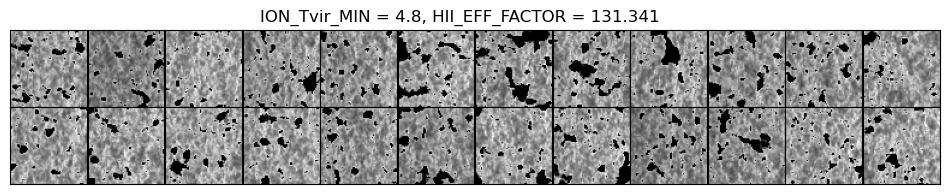

In [5]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot_grid(samples, c, row=2, col=12):
    plt.figure(figsize = (12,2))
    for i in range(24):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(f"ION_Tvir_MIN = {c[0][0]}, HII_EFF_FACTOR = {c[0][1]}")
        # plt.show()
    # plt.suptitle('simulations')
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    
plot_grid(x0[:,:,:,:], c=c0)
plot_grid(x1[:,:,:,:], c=c1)
plot_grid(x2[:,:,:,:], c=c2)
plot_grid(x3[:,:,:,:], c=c3)
plot_grid(x4[:,:,:,:], c=c4)

In [6]:
# sigma_level = 68.27
# print(x0208.shape) 
# print(los.shape)
# Tb = x0208[:,0].mean(axis=1)
# plt.plot(los[0], np.median(Tb, axis=0))
# plt.fill_between(los[0], np.percentile(Tb, 100-sigma_level, axis=0), np.percentile(Tb, sigma_level, axis=0), alpha=0.2)
# # for i in range(24):
# #     plt.plot(los[0,:], Tb[i,0,:], lw=0.3)
# # plt.plot(los[0,:], Tb[1,0,:])
# # plt.plot(los[0,:], Tb[2,0,:])
# # plt.yscale('log')
# plt.grid()
# plt.ylabel('Tb [mK]')
# plt.xlabel('z')
# plt.show()

In [7]:
def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (4*np.pi**2)

    return kbins, Pk

In [8]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
# plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
def x2Pk(x):
    Pk_vals_all = []
    for i in range(x.shape[0]):
        density_field = x[i,0,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
        if density_field.ndim == 3:
            Nx, Ny, Nz = density_field.shape
            box_size = 128#(128.0, 128.0, 1024.0) #512#
        elif density_field.ndim == 2:
            Nx, Ny = density_field.shape
            box_size = 128#(128.0, 1024.0) #512#

        # 计算物质功率谱
        k_vals, Pk_vals = calc_ps(density_field, box_size)
        # k_vals_all.append(k_vals)
        Pk_vals_all.append(Pk_vals)

    Pk_vals_all = np.array(Pk_vals_all)
    return k_vals, Pk_vals_all
    # Pk_vals_all_sim = Pk_vals_all
# plt.xscale('log')
# plt.yscale('log')

# plt.tight_layout()
# plt.legend()
# plt.show()

# # plt.subplot(2, 1, 2)
# plt.plot(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
# plt.plot(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('Power')
# plt.title('Normalized Power Spectrum')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(xmin=1e-2)
# plt.legend()
# plt.grid(True)

In [9]:
k_vals, Pk_vals_all_0_sim = x2Pk(x0)
k_vals, Pk_vals_all_1_sim = x2Pk(x1)
k_vals, Pk_vals_all_2_sim = x2Pk(x2)
k_vals, Pk_vals_all_3_sim = x2Pk(x3)
k_vals, Pk_vals_all_4_sim = x2Pk(x4)

In [10]:
ll -lth outputs

total 872M
-rw-r--r--  1 bxia34 3.1M Jun 10 18:58 Tvir4.800000190734863-zeta131.34100341796875-.npy
-rw-r--r--  1 bxia34 3.1M Jun 10 18:40 Tvir5.4770002365112305-zeta200.0-.npy
-rw-r--r--  1 bxia34 3.1M Jun 10 18:22 Tvir4.698999881744385-zeta30.0-.npy
-rw-r--r--  1 bxia34 3.1M Jun 10 18:05 Tvir5.599999904632568-zeta19.03700065612793-.npy
-rw-r--r--  1 bxia34 3.1M Jun 10 17:47 Tvir4.400000095367432-zeta131.34100341796875-.npy
-rw-r--r--  1 bxia34 848M Jun 10 16:52 model_state.pth
drwxr-xr-x 12 bxia34 4.0K Jun 10 16:28 logs/
-rw-r--r--  1 bxia34 3.1M Jun  4 20:41 test_0_0.npy
-rw-r--r--  1 bxia34 3.1M Jun  4 19:45 test_8_038.npy
-rw-r--r--  1 bxia34 3.1M Jun  4 18:00 test_2_506.npy


In [11]:
def rescale(x, ranges=ranges_dict['images']):
    x = (x + 1) / 2 * (ranges[0][1]-ranges[0][0]) + ranges[0][0]
    return x
    
def x2Tb(x):
    Tb = x[:,0].mean(axis=1)
    return Tb

torch.Size([192, 1, 64, 64])
(30,)
(192, 30)


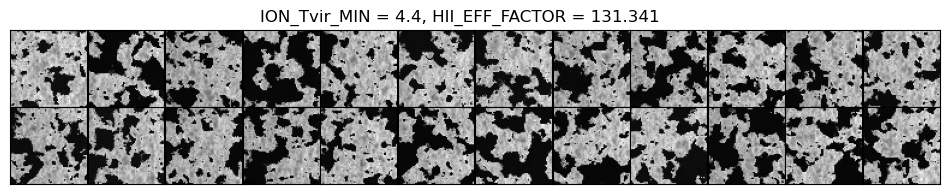

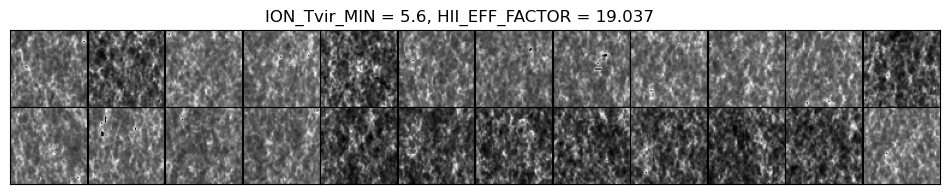

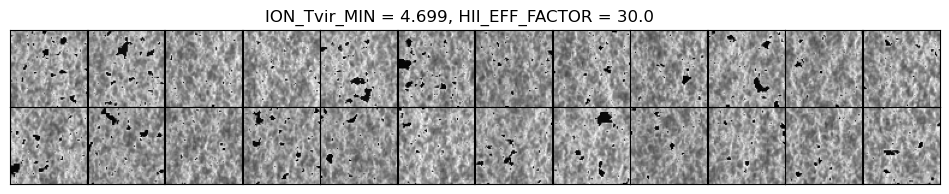

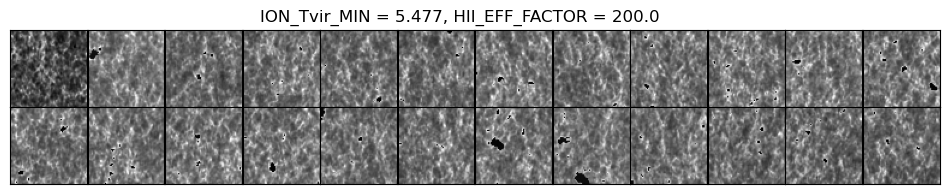

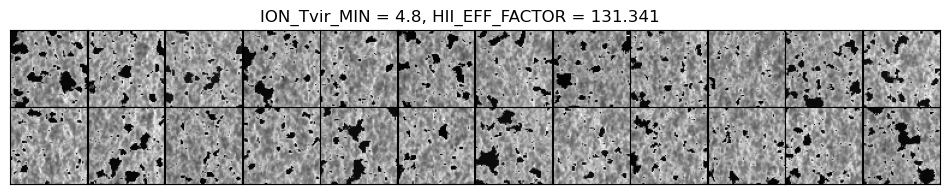

In [12]:
# x_ml = np.load("outputs/0527-1951.npy")
# x_ml = np.load("outputs/test_2_506.npy")
# x_ml = torch.from_numpy(x_ml)
# x_ml = unscale(x_ml)

x0_ml = rescale(torch.from_numpy(np.load("outputs/Tvir4.400000095367432-zeta131.34100341796875-.npy")))
x1_ml = rescale(torch.from_numpy(np.load("outputs/Tvir5.599999904632568-zeta19.03700065612793-.npy")))
x2_ml = rescale(torch.from_numpy(np.load("outputs/Tvir4.698999881744385-zeta30.0-.npy")))
x3_ml = rescale(torch.from_numpy(np.load("outputs/Tvir5.4770002365112305-zeta200.0-.npy")))
x4_ml = rescale(torch.from_numpy(np.load("outputs/Tvir4.800000190734863-zeta131.34100341796875-.npy")))

k_vals, Pk_vals_all_0_ml = x2Pk(x0_ml)
k_vals, Pk_vals_all_1_ml = x2Pk(x1_ml)
k_vals, Pk_vals_all_2_ml = x2Pk(x2_ml)
k_vals, Pk_vals_all_3_ml = x2Pk(x3_ml)
k_vals, Pk_vals_all_4_ml = x2Pk(x4_ml)

x_sim = [
    x0,
    x1,
    x2,
    x3,
    x4,
    ]
# x_ml = [x0208_ml, x0802_ml, x0000_ml]
x_ml = [
    x0_ml,
    x1_ml,
    x2_ml,
    x3_ml,
    x4_ml,
    ]

c_ml = [
    c0[0],
    c1[0],
    c2[0],
    c3[0],
    c4[0],
]


print(x0_ml.shape)
print(k_vals.shape)
print(Pk_vals_all_0_ml.shape)
# print(x_ml.shape)
# print(x_ml.shape)
# print(x_ml.max())
# print(x_ml.min())
# print(x_ml.max())
# print(x_ml.min())
# plt.imshow(x_ml[0,0,:,:])
# plt.show()


plot_grid(x0_ml[:,:,:,:], c=c0)
plot_grid(x1_ml[:,:,:,:], c=c1)
plot_grid(x2_ml[:,:,:,:], c=c2)
plot_grid(x3_ml[:,:,:,:], c=c3)
plot_grid(x4_ml[:,:,:,:], c=c4)

In [13]:
# sigma_level = 68

# for i in range(Pk_vals_all_0_ml.shape[0]):
#     plt.plot(k_vals, Pk_vals_all_0_ml[i], lw=0.1)

# plt.fill_between(k_vals, np.percentile(Pk_vals_all_0_ml, sigma_level, axis=0), np.percentile(Pk_vals_all_0_ml, 100-sigma_level, axis=0), alpha=1, facecolor=f"C0", edgecolor='black')#, hatch='/')
# print('i =', i)
# plt.yscale('log')
# # plt.xscale('log')

In [14]:
def plot_power_spectrum(Pk_pairs, params, sigma_level=68.27, alpha=0.2, redshift=None):
    fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,6), dpi=200)
    for i, (Pk0, Pk1) in enumerate(Pk_pairs):
        y0 = np.median(Pk0, axis=0)
        y1 = np.median(Pk1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        ax[0].fill_between(k_vals, np.percentile(Pk0, 100-sigma_level, axis=0), np.percentile(Pk0, sigma_level, axis=0), alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        # ax[0].fill_between(k_vals, np.percentile(Pk1, 100-sigma_level, axis=0), np.percentile(Pk1, sigma_level, axis=0), alpha=alpha/3, facecolor=f"C{i}", edgecolor='black', hatch='/')

        ax[0].plot(k_vals, y0, linestyle='-', c=f"C{i}")#, label='sim')
        # line_sim = (line_sim, Patch(facecolor='black', edgecolor='none', alpha=alpha))
        # 添加自定义图例
        # ax[0].legend(legend_elements, ['Solid line with fill_between'], handler_map={tuple: HandlerTuple(ndivide=None)})

        yerr_lower = y1 - np.percentile(Pk1, 100-sigma_level, axis=0)
        yerr_upper = np.percentile(Pk1, sigma_level, axis=0) - y1
        ax[0].errorbar(k_vals, y1, yerr=[yerr_lower, yerr_upper], linestyle=':', c=f"C{i}", marker='|')#, label='diffusion')
        
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(k_vals, (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = 0.5*(np.percentile(Pk0, sigma_level, axis=0)-np.percentile(Pk0, 100-sigma_level, axis=0))
        ax[2].plot(k_vals, (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\Delta^2(k)$ [mK$^2$]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    
    legend_line1 = Line2D([0], [0], linestyle='-', color='black')
    legend_line2 = Line2D([0], [0], linestyle=':', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['sim', 'ml'], handler_map={tuple: HandlerTuple(ndivide=None)})

    
    # solid = Line2D([0],[0], color='k', linestyle='-', label='sim')
    # solid = line_sim
    # dashed = Line2D([0],[0], color='k', linestyle='--', label='ml', marker='+')
    # legend0 = ax[0].legend(handles=[solid,dashed])
    # dashed = Line2D([0],[0], color='k', linestyle='--', label='ml', marker='+')
    # legend0 = ax[0].legend(handles=[line_sim,dashed])

    ax[0].set_title(r"power spectrum of $T_b$ at z = "+f"{los[0].mean():.2f}")
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_xlabel('k [Mpc$^{-1}$]')
    ax[1].grid()
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()

    ax[2].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    ax[2].set_xlabel('k [Mpc$^{-1}$]')
    ax[2].grid()
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])
    # xs.set_xticks([])
    # xs = ax[1].secondary_xaxis('top')
    # ax[2].legend()
        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()


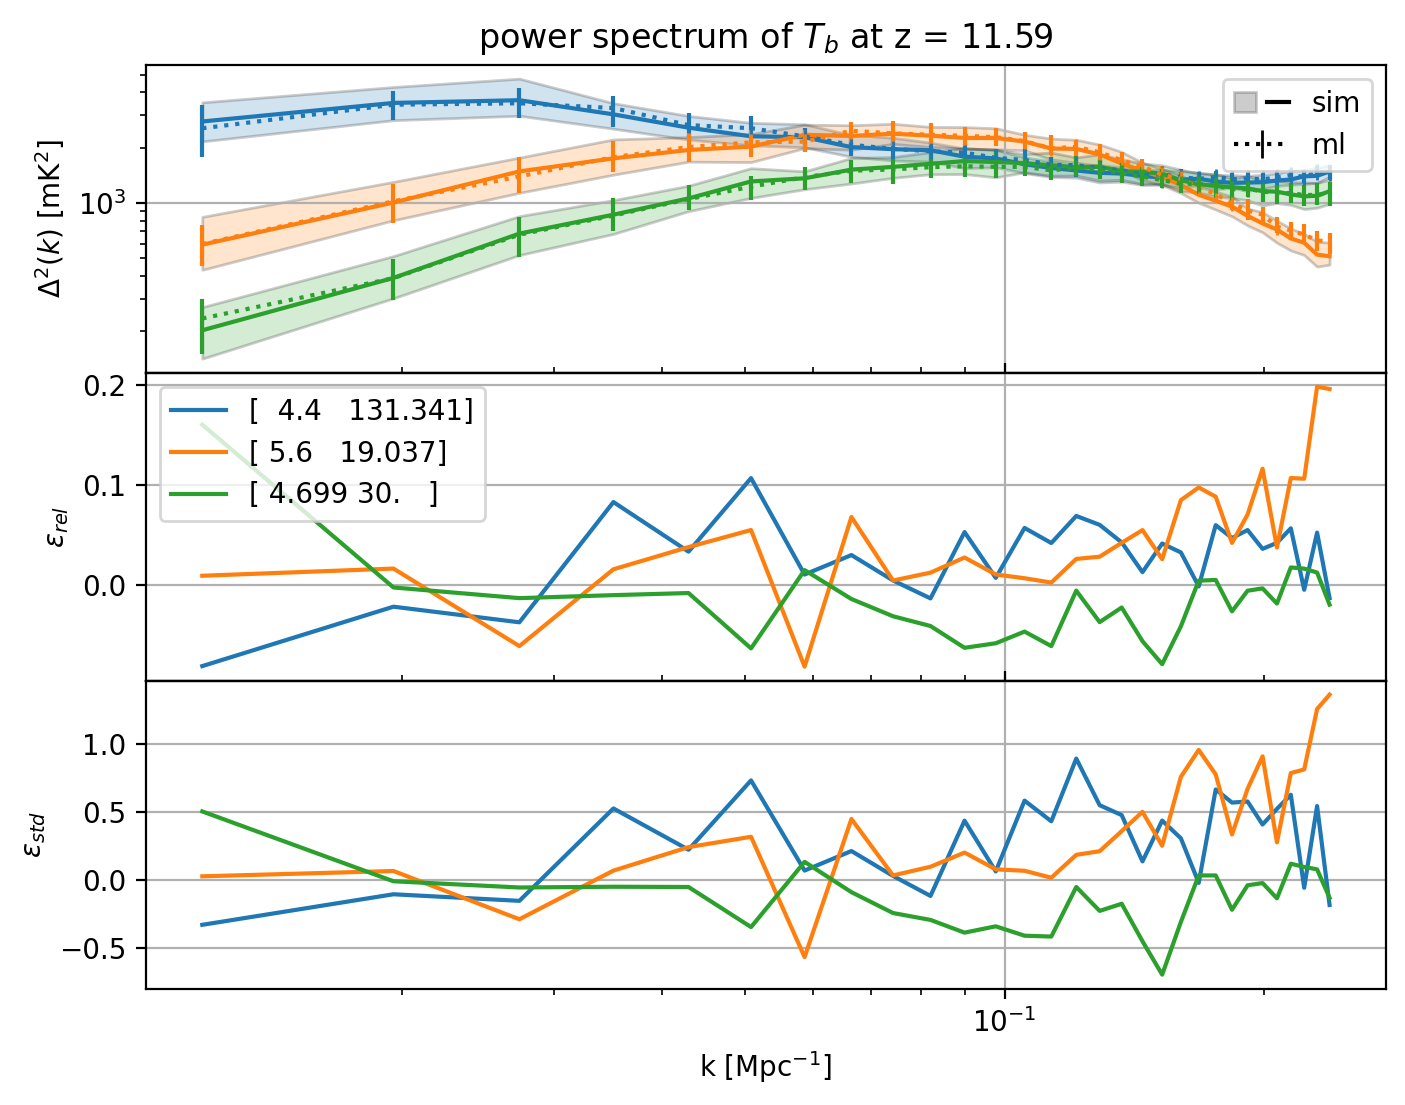

In [15]:
plot_power_spectrum(
    [
        (Pk_vals_all_0_sim, Pk_vals_all_0_ml), 
        (Pk_vals_all_1_sim, Pk_vals_all_1_ml),
        (Pk_vals_all_2_sim, Pk_vals_all_2_ml), 
        # (Pk_vals_all_3_sim, Pk_vals_all_3_ml),
        # (Pk_vals_all_4_sim, Pk_vals_all_4_ml),
    ],
    params = [
        c0[0], 
        c1[0],
        c2[0], 
        # c3[0], 
        # c4[0],
    ]
    )
# plt.grid()
# plot_power_spectrum(Pk_vals_all_diffusion, Pk_vals_all_diffusion)

In [16]:
def plot_global_signal(x_pairs, params, sigma_level=68.27, alpha=0.2):
    fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,6), dpi=200)
    for i, (x0, x1) in enumerate(x_pairs):
        # print(Tb0.shape)
        Tb0 = x2Tb(x0)
        Tb1 = x2Tb(x1)
        
        y0 = np.median(Tb0, axis=0)
        y1 = np.median(Tb1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        ax[0].fill_between(los[0], np.percentile(Tb0, 100-sigma_level, axis=0), np.percentile(Tb0, sigma_level, axis=0), alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        # ax[0].fill_between(los[0], np.percentile(Tb1, 100-sigma_level, axis=0), np.percentile(Tb1, sigma_level, axis=0), alpha=alpha/3, facecolor=f"C{i}", edgecolor='black', hatch='/')

        yerr_lower = y1 - np.percentile(Tb1, 100-sigma_level, axis=0)
        yerr_upper = np.percentile(Tb1, sigma_level, axis=0) - y1
        ax[0].errorbar(los[0], y1, yerr=[yerr_lower, yerr_upper], linestyle=':', c=f"C{i}", marker='|')#, label='diffusion')

        ax[0].plot(los[0], y0, linestyle='-', c=f"C{i}")#, label='sim')
        # ax[0].plot(los[0], y1, lw=2, linestyle=':', c=f"C{i}")#, label='diffusion')
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(los[0], (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = 0.5*(np.percentile(Tb0, sigma_level, axis=0)-np.percentile(Tb0, 100-sigma_level, axis=0))
        ax[2].plot(los[0], (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")

    # ax[0].set_xscale('log')
    # ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\langle T_b \rangle$ [mK]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    # solid = Line2D([0],[0], color='k', lw=1, linestyle='-', label='sim')
    # dashed = Line2D([0],[0], color='k', lw=1, linestyle='--', label='ml')
    # legend0 = ax[0].legend(handles=[solid,dashed])
    
    legend_line1 = Line2D([0], [0], linestyle='-', color='black')
    legend_line2 = Line2D([0], [0], linestyle=':', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['sim', 'ml'], handler_map={tuple: HandlerTuple(ndivide=None)})

    ax[0].set_title(r"global temperature")
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    # ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_xlabel('Redshift')
    # xs = ax[1].secondary_xaxis('top')
    # xs.set_xticklabels([])
    # xs.set_xticks([],[])
    ax[1].grid()
    
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()

    # ax[1].legend()

    # ax[2].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    
    ax[2].set_xlabel('Redshift')
    # ax[2].set_xlabel('k [Mpc$^{-1}$]')
    ax[2].grid()
    
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()

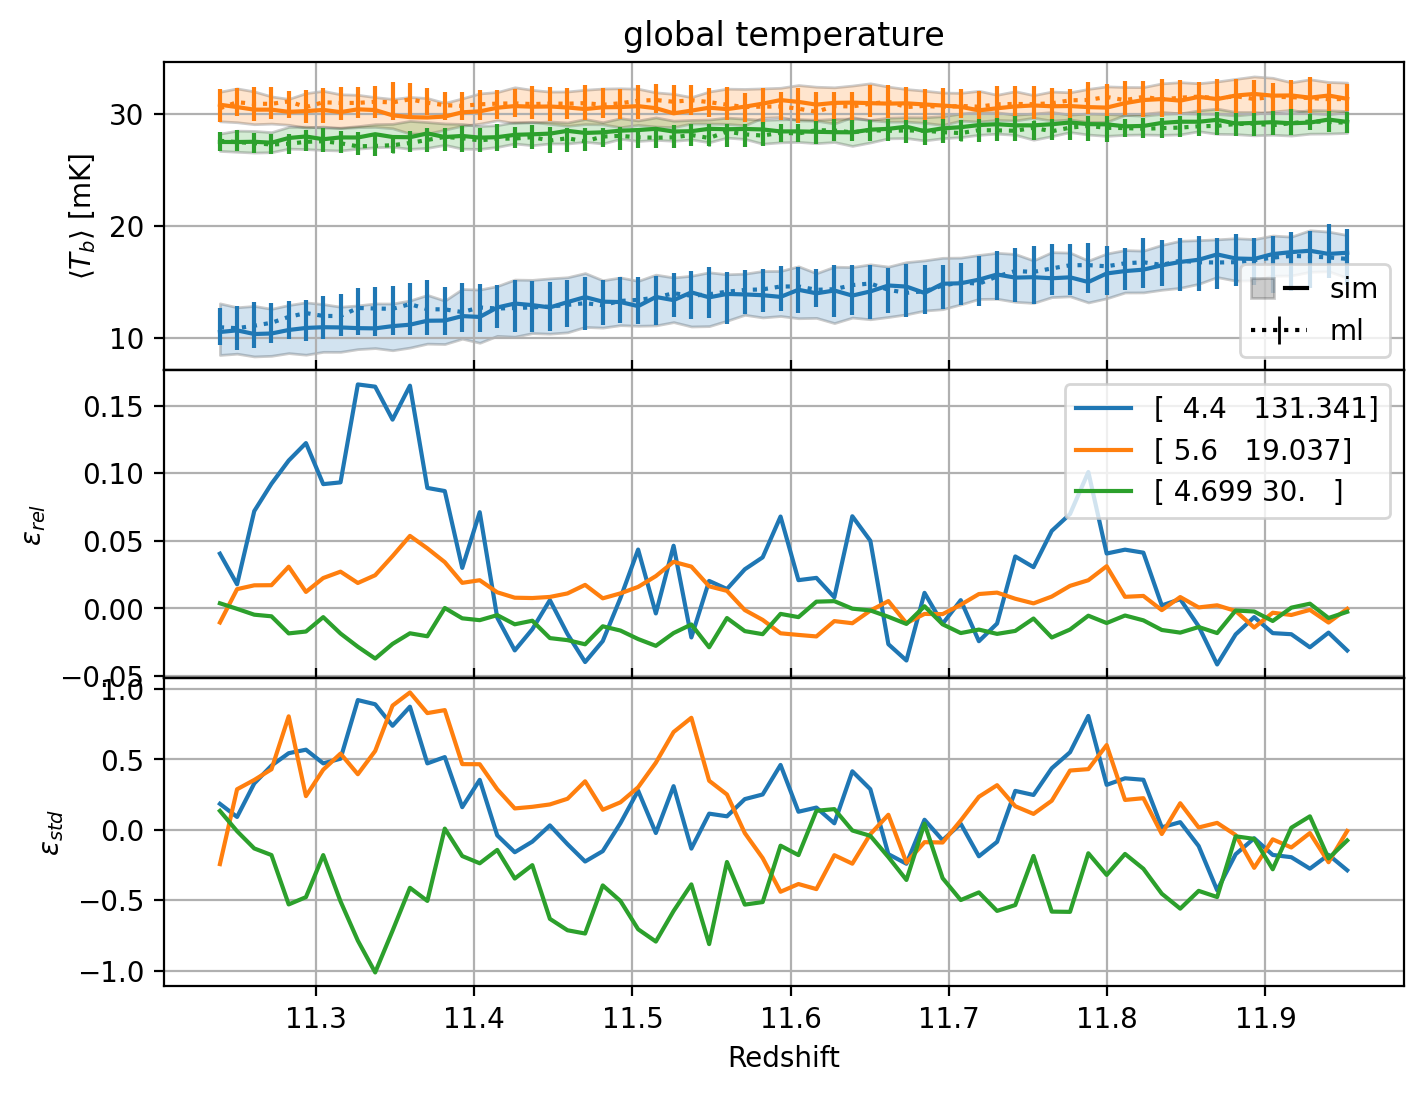

In [17]:
plot_global_signal(
    [
        (x0,x0_ml),
        (x1,x1_ml),
        (x2,x2_ml),
        # (x3,x3_ml),
        # (x4,x4_ml),
        ],
    params = [
        c0[0], 
        c1[0],
        c2[0], 
        # c3[0], 
        # c4[0],
    ],   
    )

In [18]:
x0.shape

torch.Size([192, 1, 64, 64])

In [19]:
x0.device

device(type='cpu')

In [20]:
my_list = [[],[],[]]
print(my_list)
my_list[0] = [1,2,3]
my_list[2] = [5,4,32,1]
print(my_list)
my_list = [[]]*3
print(my_list)

[[], [], []]
[[1, 2, 3], [], [5, 4, 32, 1]]
[[], [], []]


In [21]:
(10-17) % 2

1

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def sort_by_l(S2, jthetas, L):
    # print("S2.shape =", S2.shape)
    S2_sorted = np.empty((L, S2.shape[0], int(S2.shape[1]/L)))
    jthetas_sorted = np.empty((L, S2.shape[1]//L, 2, 2))
    # jthetas_sorted = [[]]*L
    num_updated = np.zeros(L, dtype=int)

    # print("jthetas =", jthetas)
    for i, jtheta in enumerate(jthetas):
        index = (jtheta[1][1]-jtheta[1][0]) % L
        # print("index =", index)
        S2_sorted[index, :, num_updated[index]] = S2[:,i]
        # print("sort_by_l", jthetas_sorted[index*L+num_updated[index]], np.array(jtheta))
        jthetas_sorted[index, num_updated[index]][0] = jtheta[0]
        jthetas_sorted[index, num_updated[index]][1] = jtheta[1]
        # print("S2_sorted[:, index*L+num_updated[index]] =", S2_sorted[:, index*L+num_updated[index]])
        # jthetas_sorted[index] = jtheta
        # print("jtheta =", jtheta)
        # print("jthetas_sorted.shape =", jthetas_sorted.shape)
        # print("left =", jthetas_sorted[index*L+num_updated[index],:])
        # print("right =", np.array(jtheta))
        # jthetas_sorted[index*L+num_updated[index],:] = np.array(jtheta)
        # print("index, S2_sorted.shape =", index, np.shape(S2_sorted))
        num_updated[index] += 1
    # print("index*L+num_updated[index]", index*L+num_updated[index])
    # print("i =", i)

    S2_sorted = np.array(S2_sorted)
    # print("S2_sorted.shape", S2_sorted.shape)
    # print("S2_sorted", S2_sorted)
    jthetas_sorted = np.array(jthetas_sorted)
    # print('sort_by_l S2_sorted.shape',S2_sorted.shape)
    # print('sort_by_l jthetas_sorted.shape', jthetas_sorted.shape)
    return S2_sorted, jthetas_sorted


def calculate_sorted_S2(x, S, J, L, jthetas):
    S2 = np.mean(S(x.to(device))[:,0].cpu().numpy(), axis=(2,3))
    # print("jthetas.shape =", jthetas.shape)
    for j1 in range(J):
        for j2 in range(J):
            if j2>j1:
                # print("j1", j1, "j2", j2)
                index = [jtheta[0] == (j1,j2) for jtheta in jthetas]
                # print(index)
                # print(jthetas[index])
                # cache = S2[:,index]
                # print(index)
                if (j1,j2) == (0,1):
                    S2_reduced = S2[:,index]
                    jthetas_reduced = np.array(jthetas[index])
                    # index_reduced = index
                else:
                    S2_reduced = np.concatenate((S2_reduced, S2[:,index]), axis = 1)
                    jthetas_reduced = np.concatenate([jthetas_reduced, np.array(jthetas[index])], axis = 0)
                    # index_reduced = np.concatenate((index_reduced, index))
    # print("calculate_S2 S2_reduced.shape", S2_reduced.shape)
    # print("calculate_S2 jthetas_reduced.shape", jthetas_reduced.shape)
    # print(jthetas_reduced[:3])

    S2_sorted, jthetas_sorted = sort_by_l(S2_reduced, jthetas_reduced, L)
    # print(index_reduced.shape)
    return S2_sorted, jthetas_sorted

def calculate_S2(x_pairs, params, sigma_level=68.27, alpha=0.2, J=5, L=4, M=64, N=64):
    for i, (x0, x1) in enumerate(x_pairs):
        # get jthetas and S
        if i == 0:
            S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
            jthetas = []
            for dicts in S(x0.to(device)):
                jthetas.append([dicts['j'], dicts['theta']])
            jthetas = np.array(jthetas)
            S = Scattering2D(J, (M, N), L=L).to(device)
            # print("type(dicts[j])", type(dicts['j']), dicts['j'])
        # print("plot_scattering_transform jthetas.shape", jthetas.shape)
        # print(jthetas[0], jthetas[1], jthetas[160])
        S2_reduced, jthetas_reduced = calculate_sorted_S2(x0, S, J, L, jthetas)
        # print("S2_reduced.shape =", S2_reduced.shape)
        return S2_reduced, jthetas_reduced

In [43]:
S2_reduced, jthetas_reduced = calculate_S2(
    [
        (x0,x0_ml),
        (x1,x1_ml),
        # (x2,x2_ml),
        # (x3,x3_ml),
        # (x4,x4_ml),
        ],
    params = [
        c0[0], 
        c1[0],
        # c2[0], 
        # c3[0], 
        # c4[0],
    ],   
)

print(S2_reduced.shape, jthetas_reduced.shape)
print(jthetas_reduced[2])

/scratch/439684/ipykernel_143551/216983055.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)


(4, 192, 40) (4, 40, 2, 2)
[[[0. 1.]
  [0. 2.]]

 [[0. 1.]
  [1. 3.]]

 [[0. 1.]
  [2. 0.]]

 [[0. 1.]
  [3. 1.]]

 [[0. 2.]
  [0. 2.]]

 [[0. 2.]
  [1. 3.]]

 [[0. 2.]
  [2. 0.]]

 [[0. 2.]
  [3. 1.]]

 [[0. 3.]
  [0. 2.]]

 [[0. 3.]
  [1. 3.]]

 [[0. 3.]
  [2. 0.]]

 [[0. 3.]
  [3. 1.]]

 [[0. 4.]
  [0. 2.]]

 [[0. 4.]
  [1. 3.]]

 [[0. 4.]
  [2. 0.]]

 [[0. 4.]
  [3. 1.]]

 [[1. 2.]
  [0. 2.]]

 [[1. 2.]
  [1. 3.]]

 [[1. 2.]
  [2. 0.]]

 [[1. 2.]
  [3. 1.]]

 [[1. 3.]
  [0. 2.]]

 [[1. 3.]
  [1. 3.]]

 [[1. 3.]
  [2. 0.]]

 [[1. 3.]
  [3. 1.]]

 [[1. 4.]
  [0. 2.]]

 [[1. 4.]
  [1. 3.]]

 [[1. 4.]
  [2. 0.]]

 [[1. 4.]
  [3. 1.]]

 [[2. 3.]
  [0. 2.]]

 [[2. 3.]
  [1. 3.]]

 [[2. 3.]
  [2. 0.]]

 [[2. 3.]
  [3. 1.]]

 [[2. 4.]
  [0. 2.]]

 [[2. 4.]
  [1. 3.]]

 [[2. 4.]
  [2. 0.]]

 [[2. 4.]
  [3. 1.]]

 [[3. 4.]
  [0. 2.]]

 [[3. 4.]
  [1. 3.]]

 [[3. 4.]
  [2. 0.]]

 [[3. 4.]
  [3. 1.]]]


In [44]:
print(abs(2-3)%4)
print((2-3)%4)

1
3


In [49]:
def plot_scattering_transform(S2, jthetas, sigma_level=68.27, alpha=0.2, J=5, L=4, M=64, N=64):
    print(S2.shape, jthetas.shape)
    print("---"*30)
    S2_reshape = S2.reshape(S2.shape[0], S2.shape[1], S2.shape[2]//L, L)
    jthetas_reshape = jthetas.reshape(jthetas.shape[0],jthetas.shape[1]//L, L,jthetas.shape[2],jthetas.shape[3])
    print(S2_reshape.shape, jthetas_reshape.shape)
    print("---"*30)
    print(jthetas_reshape)
    print("---"*30)
    # print(S2)
plot_scattering_transform(S2_reduced, jthetas_reduced)

(4, 192, 40) (4, 40, 2, 2)
------------------------------------------------------------------------------------------
(4, 192, 10, 4) (4, 10, 4, 2, 2)
------------------------------------------------------------------------------------------
[[[[[0. 1.]
    [0. 0.]]

   [[0. 1.]
    [1. 1.]]

   [[0. 1.]
    [2. 2.]]

   [[0. 1.]
    [3. 3.]]]


  [[[0. 2.]
    [0. 0.]]

   [[0. 2.]
    [1. 1.]]

   [[0. 2.]
    [2. 2.]]

   [[0. 2.]
    [3. 3.]]]


  [[[0. 3.]
    [0. 0.]]

   [[0. 3.]
    [1. 1.]]

   [[0. 3.]
    [2. 2.]]

   [[0. 3.]
    [3. 3.]]]


  [[[0. 4.]
    [0. 0.]]

   [[0. 4.]
    [1. 1.]]

   [[0. 4.]
    [2. 2.]]

   [[0. 4.]
    [3. 3.]]]


  [[[1. 2.]
    [0. 0.]]

   [[1. 2.]
    [1. 1.]]

   [[1. 2.]
    [2. 2.]]

   [[1. 2.]
    [3. 3.]]]


  [[[1. 3.]
    [0. 0.]]

   [[1. 3.]
    [1. 1.]]

   [[1. 3.]
    [2. 2.]]

   [[1. 3.]
    [3. 3.]]]


  [[[1. 4.]
    [0. 0.]]

   [[1. 4.]
    [1. 1.]]

   [[1. 4.]
    [2. 2.]]

   [[1. 4.]
    [3. 3.]]]


  [[[2. 3.]
    

In [ ]:
# from kymatio.torch import Scattering2D
# from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# redshifts = np.load('/scratch/dkn16/redshifts_256.npy')
# redshifts = los[0]
# nchunks=6
# data0 = torch.tensor(total_GAN[0][:,:,nchunks*64:(nchunks+2)*64],device = "cuda",dtype = torch.float32)
data0 = x0.to(device)

print(x0.shape)
print(len(x_sim))
# x_ml[0].shape
# Set the parameters of the scattering transform.
# J = 5
# L = 4
J, L, M, N = 5, 4, 64, 64

S = Scattering2D(J, (M, N), L=L, out_type='list').cuda()
jthetas = []
for dicts in S(data0):
    jthetas.append([dicts['j'], dicts['theta']])
jthetas = np.array(jthetas)
# xlables = []
# # Define a Scattering2D object.

S = Scattering2D(J, (M, N), L=L).cuda()

torch.Size([192, 1, 64, 64])
5


/scratch/435160/ipykernel_109752/2578189709.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)


In [ ]:
print(jthetas.shape)
# print(jthetas)

(181, 2)


In [ ]:
S_ml = []
S_sim = []
for i in range(len(x_sim)):
    # data0 = torch.tensor(total_GAN[i][:,:,nchunks*64:(nchunks+2)*64],device = "cuda",dtype = torch.float32)
    data0 = x_sim[i][:,0].to(device)
    # data0 = x0000[:,0].to(device)
    Sx1 = np.mean(S(data0).to('cpu').numpy(),axis=(2,3))
    for j in [0,3,6]:
        index = [a[0] == (j,) for a in jthetas]
        # print(index)
        # print("index =", index)
        # print(Sx1.shape)
        cache = Sx1[:,index]
        # print("cache.shape =", cache.shape)
        #print(cache.shape)
        # print("cache =", cache)
        if j == 0:
            S1 = cache
        else:
            S1 = np.concatenate((S1,cache),axis = 1)
        #xlables.append((j))
        # print('done, i,j =', i,',', j)
    print("S1.shape =", S1.shape)
    for j in [0,3,6]:
        for j2 in [0,3,6]:
            if j2<j:
                continue
            index = [a[0] == (j,j2) for a in jthetas]
            cache = Sx1[:,index]
            # print("cache.shape =", cache.shape)
            S1 = np.concatenate((S1,cache),axis = 1)
            #xlables.append((j2,j))
    # print(S1.shape)

    # data1 = torch.tensor(total_test[i][:,:,nchunks*64:(nchunks+2)*64],device = "cuda",dtype = torch.float32)
    data1 = x_ml[i][:,0].to(device)
    Sx1 = np.mean(S(data1).to('cpu').numpy(),axis=(2,3))

    for j in [0,3,6]:
        index = [a[0] == (j,) for a in jthetas]
        #print(index)
        cache = Sx1[:,index]
        #print(cache.shape)
        if j == 0:
            St = cache
        else:
            St = np.concatenate((St,cache),axis = 1)
        #xlables.append((j))
    for j in [0,3,6]:
        for j2 in [0,3,6]:
            if j2<j:
                continue
            index = [a[0] == (j,j2) for a in jthetas]
            cache = Sx1[:,index]
            St = np.concatenate((St,cache),axis = 1)
            #xlables.append((j2,j))
    # St.shape
    # print("S1.shape =", S1.shape)
    # print("St.shape =", St.shape)
    S_sim.append(S1)
    S_ml.append(St)

S1.shape = (192, 8)
S1.shape = (192, 8)
S1.shape = (192, 8)
S1.shape = (192, 8)
S1.shape = (192, 8)


In [ ]:
S_ml[0].shape

(192, 24)

<Figure size 4000x1500 with 0 Axes>

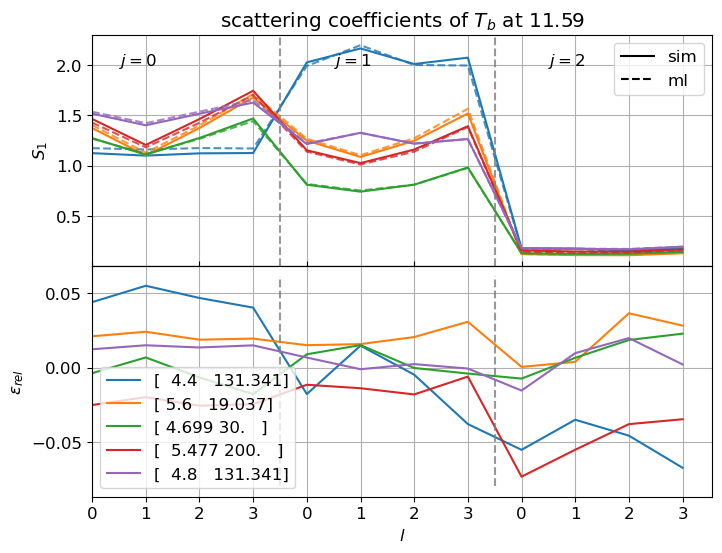

In [ ]:
plt.rc('font',family = 'sans-serif',size =12)
fig = plt.figure(dpi=500,figsize = (8,3))
# gs = fig.add_gridspec(2, 1, height_ratios=( 2.5,1),wspace=0.05, hspace=0.0)
# Create the Axes.
# ax = fig.add_subplot(gs[0, 0])

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)
for i in range(len(x_sim)):
    Sx1 = S_ml[i]
    #print(Sx1.shape)
    # sx1_per = np.percentile(Sx1,[5,95],axis=0)
    ax[0].plot(np.mean(Sx1,axis=(0))[0:12],c=f"C{i}",linestyle='--',alpha = 0.8)
    #ax.fill_between(range(12),sx1_per[0][0:12],sx1_per[1][0:12],color = colors[i],alpha = 0.2)
    
    Sx = S_sim[i]
    sx_per = np.percentile(Sx,[5,95],axis=0)
    line2, = ax[0].plot(np.mean(Sx,axis=(0))[0:12],c=f"C{i}")
    #ax.fill_between(range(12),sx_per[0][0:12],sx_per[1][0:12],color = colors[i],alpha = 0.4)
    # legends1.append((line1,line2))
    # print("ax, i =", i)
# ax.set_title(f'z={redshifts[86+nchunks*64+64]:.3f}')
ax[0].set_title(f'scattering coefficients of $T_b$ at '+f"{los[0].mean():.2f}")
#plt.ylim(0,3.1)
ax[0].set_ylabel(r'$S_1$')
#plt.ylim(0,3.1)
#print(ax.get_ylim())
ax[0].set_ylim(ax[0].get_ylim()[0],ax[0].get_ylim()[1])
for j in range(3):
    ax[0].text(0.5+4*j,2,r'$j={%d}$'%(j))

# ax[0].set_xticks(range(12),[a[0] for a in jthetas[1:13][:,1]])
# l = ax[0].legend([a for a in legends1],legends,handlelength = 5, handler_map={tuple: HandlerTuple(ndivide=2,)})
ax[0].vlines([3.5,7.5], ax[0].get_ylim()[0], ax[0].get_ylim()[1], colors='tab:grey',alpha = 0.8, linestyle='--')
ax[0].grid()
# ax[0].set_yscale('log')
# ax[0].legend()
solid = Line2D([0],[0], color='k', linestyle='-', label='sim')
dashed = Line2D([0],[0], color='k', linestyle='--', label='ml')
legend0 = ax[0].legend(handles=[solid,dashed])

# ax[1] = fig.add_subplot(gs[1, 0],sharex=ax)
# print(len(S_sim))
for i in range(len(x_sim)):
    Sx = S_sim[i]
    Sx1 = S_ml[i]
    Sx = np.mean(Sx,axis = 0)
    Sx1 = np.mean(Sx1,axis = 0)
    ax[1].plot(Sx1[0:12][Sx[0:12]>0.1]/Sx[0:12][Sx[0:12]>0.1]-1,c=f"C{i}",label=f"{c_ml[i].numpy()}")
    # print("ax1, i =", i)
# xs = ax[1].secondary_xaxis('top')
# xs.set_xticks(range(12),[])
# ax[1].set_yticks([0.0,0.2])

xs = ax[1].secondary_xaxis('top')
xs.set_xticklabels([])
# ax[1].set_ylim(ymin=0.0, ymax=0.15)
ax[1].vlines([3.5,7.5],ax[1].get_ylim()[0],ax[1].get_ylim()[1],colors='tab:grey',alpha = 0.8,linestyle='--')
# ax[1].set_xlim(ax[1].get_xlim()[0],ax[1].get_xlim()[1])
# ax[1].hlines(0.1,ax[1].get_xlim()[0],ax[1].get_xlim()[1],colors='tab:grey',alpha = 0.8,linestyle='-.')
ax[1].set_xticks(range(12), [a[0] for a in jthetas[1:13][:,1]])
#xs.set_xticks([8,9,10,11],['','','',''])
ax[1].legend()
ax[1].set_xlim(xmin=0)
ax[1].set_xlabel(r'$l$')
ax[1].set_ylabel(r'$\epsilon_{rel}$')
ax[1].grid()
# plt.savefig(f'./tests/S1z={redshifts[86+nchunks*64+64]:.3f}.pdf',bbox_inches='tight')

plt.subplots_adjust(hspace=0)